## Demo of Feeder Simulations with OpenDSS
This notebook demonstrates how to run powerflow simulations with OpenDSS and retrieve the simulated voltage and current measurement data.  
The documentation for opendssdirect can be found [here](http://dss-extensions.org/OpenDSSDirect.py/index.html). 

This notebook primarily uses functions contained in the `simulations_utils` which are convenient wrappers for working with `OpenDSSDirect`. To get more insight into the `OpenDSSDirect` API itself, you will likely need to dig into the functions from `simulations_utils`. 

In [66]:
import numpy as np
import pandas as pd
import opendssdirect as dss
import matplotlib.pyplot as plt
import simulation_utils as sims

%matplotlib inline

import importlib

importlib.reload(sims);

### 1. Load a feeder model. 
OpenDSS comes packaged with some IEEE network models. By loading a model, all the model parameters get instantiated. 
Some of the models included with OpenDSS (which have been copied into this repo) are:
1. IEEE 13 bus
2. IEEE 34 bus
3. IEEE 37 bus

In [67]:
# The location of the .dss file specifying the model.
model_loc = "./Models/13Bus/IEEE13Nodeckt.dss"
# Activate the model in OpenDSS
dss.run_command("Redirect " + model_loc);

In [68]:
# Get the names of all buses in the model
bus_names = dss.Circuit.AllBusNames()
nbuses = len(bus_names)
print("Model contains", nbuses, "buses")

# Get the names of all nodes in the model
# Nodes are the individual phases at every bus
node_names = dss.Circuit.AllNodeNames()
nnodes = len(node_names)
print("Model contains", nnodes, "nodes")

# Get the names of all lines in the model
line_names = dss.Lines.AllNames()
nlines = len(line_names)
print("Model contains", nlines, "lines")

Model contains 16 buses
Model contains 41 nodes
Model contains 12 lines


In [69]:
print(bus_names)

['sourcebus', '650', 'rg60', '633', '634', '671', '645', '646', '692', '675', '611', '652', '670', '632', '680', '684']


## Network connectors
There are several types of connectors (circuit elements that carry current between buses) in the network. Lines are only one, we can also have transformers. The following convenience function allows us to return certain types of connectors. 

In [70]:
lines_and_transformers = sims.get_connectors(qualified=["Line", "Transformer"])
print(lines_and_transformers)

['Transformer.sub', 'Transformer.reg1', 'Transformer.reg2', 'Transformer.reg3', 'Transformer.xfm1', 'Line.650632', 'Line.632670', 'Line.670671', 'Line.671680', 'Line.632633', 'Line.632645', 'Line.645646', 'Line.692675', 'Line.671684', 'Line.684611', 'Line.684652', 'Line.671692']


### 2. Run powerflow
The powerflow problem is a fundamental one in electrical networks. It consists of determining the voltages and currents that will be observed throughout at the network for a given set of power demands. Practically, we tend to know the power demanded or produced by network entities, and we want to work from this to determine the currents and voltages that will result. These currents and voltages are also the measurements that we obtain from PMU sensors. 

Therefore, to generate "synthetic" PMU data for a network, we essentially need to run powerflow. 

We can start by running powerflow given the default load values in the model. Once powerflow is run, we retrieve the resulting voltages and currents. 

OpenDSS has a strange structure which is not fully, flexibly object oriented. Therefore, to access the properties of a certain object, such as the voltage of a bus, we have to set it as the active object in the circuit. This is demonstrated below as we retrieve the voltages of each phase after solving the PF. Unfortunately to make an element active is not very consistent. For example, loads can be activated through ```dss.Loads.Name()``` while buses must be activated through ```dss.Circuit.SetActiveBus()``` _not_ ```dss.Bus.Name()```. 

In [71]:
# Run / solve powerflow
dss.Solution.Solve();

Getting the voltages and currents generated by the simulation is not totally straightforward. For example, the following line retrieves the voltages at a single bus by first setting the bus to be _active_. 

In [72]:
bus = bus_names[3]
dss.Circuit.SetActiveBus(bus)
busvolt = dss.Bus.Voltages()
print("Voltages at", bus, busvolt)

Voltages at 633 [2426.425943474452, -109.95862245792392, -1300.0214661176276, -2096.2770897808787, -1120.4367179288215, 2128.6149747573713]


The voltages are returned as an array of real and imaginary parts for the volatge on each phase at the bus. Therefore, `len(busvolt)` will be $2 \times$ the number of phases on the bus. 

To make things more convenient, the functions `v2dict` and `i2dict` retrieve all the voltage and current measurements from the model. These are returned in dictionaries, where the keys are formatted to convey what the specific data corresponds to and can be used to instantiate streams for the data. 

In [73]:
v = sims.v2dict(bus_names)
i = sims.i2dict(lines_and_transformers)

In [74]:
key_list = [key for key in v.keys()]
print(key_list[0], v[key_list[0]])
print(key_list[1], v[key_list[1]])

sourcebus/VAM 66393.52580623927
sourcebus/VAA 29.99273887927827


### 3. Change loads and run power flow
Now we want to generate a _time series_ of voltages and currents, where they vary as loads in the system change. We will do this by iteratively changing the load at each bus, running powerflow, and saving the solved voltages and currents. 

We could define load curves, but for simplicity, we will vary the loads randomly. For convenience, we do so by applying a randomized scaling to the original load in the model. That is, if the original load of bus $b$ is $l_b$, the load at time $t$ will be set to $l_b \times s(b, t)$ where $s$ is a matrix we create. 

In this case, we choose $s$ to be random uniform and uncorrelated across nodes. The following cell gets the existing load settings in the model and uses them to generate a matrix of randomized loads. 

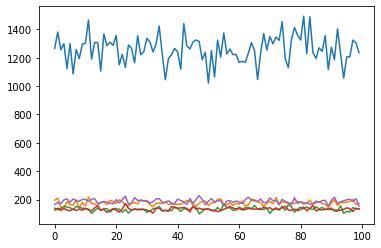

In [75]:
T = 100  # Number of time points to simulate

# Get the original loads
load, load_names = sims.get_loads()
nloads = len(load_names)

# Generate the randomized scaling factors
mu = 1.1
sig = 0.1
s = np.random.normal(loc=mu, scale=sig, size=[nloads, T])

# Generate the new load values by scaling the original loads with randomized s
new_load = s * load[:, np.newaxis]

# Visualize some of the load curves
plt.plot(new_load[0:5, :].T);

Now to iteratively run the simulation for each load setting and retrieve the resulting voltages and currents...

The function `simulate_network` does this all for you. It has the signature `simulate_network(loads, load_names, contypes=['Line', 'Transformer'])`. The first argument is the desired load values in an $n\times T$ matrix (as created above), where $n$ is the number of loads we want to set. The second argument is the names of the loads to set (as returned by `get_loads()` above). Finally, the optional argument `contypes` specifies which types of connections we want to return current data for.  

The function returns dictionaries of voltage and current, with the sames keys as `v2dict` and `i2dict` respectively.

In [76]:
V, I = sims.simulate_network(new_load, load_names)

Running simulation:   0%|          | 0/99 [00:00<?, ?it/s]

Let's look at one of the resulting voltage magnitudes. 

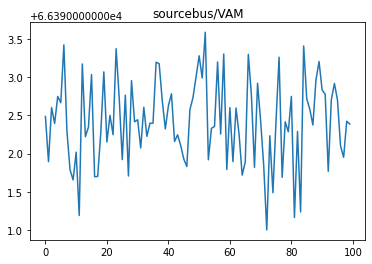

In [79]:
key_list = [key for key in V.keys()]

plt.plot(V[key_list[0]])
plt.title(key_list[0]);

And one of the resulting current magnitudes. 

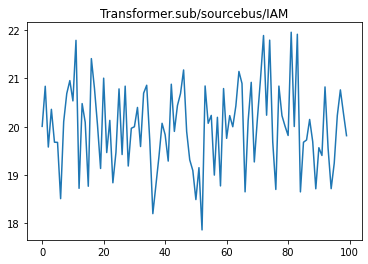

In [80]:
key_list = [key for key in I.keys()]

plt.plot(I[key_list[0]])
plt.title(key_list[0]);